## Import Packages

In [ ]:
!pip install fuzzywuzzy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import gensim
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
import matplotlib.pyplot as plt
from itertools import chain
import string
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from datetime import datetime
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from dateutil import parser
import pandas as pd
from fuzzywuzzy import fuzz

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Import Data

In [ ]:
root_dir = '/content/drive/MyDrive/audace_trial/corpus/english_modern/canadian_newstream'

In [ ]:
out_dir = "/content/drive/MyDrive/audace_trial/cleaned_corpus/english_modern/"

# Data Cleaning Functions

In [ ]:
def get_files(root_dir):
  # Define a list to store the text
  file_list = []

  # Recursively search for files in the root directory and its subdirectories
  for subdir, dirs, files in os.walk(root_dir):
      for fil in files:
          obj = {}
          file_path = os.path.join(subdir, fil)
          seg = subdir.split('/')
          obj['term'] = seg[-1]
          f = open(file_path, 'r')
          text = f.read()
          obj['text'] = text
          f.close
          file_list.append(obj)
  return file_list

In [ ]:
def extract_doc (file_list):
  regex_pattern = "(.*?)Database:"
  doc_list = []
  for obj in file_list:
    matches = re.finditer(regex_pattern, obj['text'], re.DOTALL)
    for mat in matches:
      doc = {}
      extracted_text = mat.group(1).strip()
      doc['text'] = extracted_text
      doc['term'] = obj['term']
      doc_list.append(doc)
  return doc_list

In [ ]:
def documentation(doc_list):
  cont_list = []
  pattern0 = r"Full text:(.*?)Location:"
  pattern1 = r"document ID:(.*?)\n"
  pattern2 = r"Source type:(.*?)\n"
  pattern3 = r"Publication date:(.*?)\n"
  pattern4 = r"^.*?Subject:.*?$"
  pattern5 = r"^.*?Business indexing term:.*?$"
  subject_pattern = r"Subject:(.*?)\n"
  subject = ["NA"]
  source = "NA"
  date = "NA"
  for doc in doc_list:
    t = {}
    m0 = re.search(pattern0, doc['text'], re.DOTALL)
    cont = m0.group(1).strip()
    m1 = re.search(pattern1, doc['text'], re.DOTALL)
    id = m1.group(1).strip()
    m2 = re.search(pattern2, doc['text'], re.DOTALL)
    if m2:
      source = m2.group(1).strip()
    m3 = re.search(pattern3, doc['text'], re.DOTALL)
    if m3:
      date = m3.group(1).strip()
    m6 = re.search(subject_pattern, doc['text'], re.DOTALL)
    if m6:
      subject = m6.group(1).strip()
      subject = subject.split("; ")
    m4 = re.search(pattern4, cont, re.DOTALL)
    m5 = re.search(pattern5, cont, re.DOTALL)
    if m5:
      cont = re.sub(pattern5, "", cont, flags=re.MULTILINE)
    if m4:
      cont = re.sub(pattern4, "", cont, flags=re.MULTILINE)
    t['term'] = doc['term']
    t['full_text'] = cont
    t['date'] = date
    t['source'] = source
    t['id'] = id
    t['subject'] = subject
    cont_list.append(t)
  return cont_list



In [ ]:
def rm_duplicates(cont_list):
  unique_data = []
  seen_texts = set()
  for entry in cont_list:
      full_text = entry['full_text'][:100]
      if full_text not in seen_texts:
          unique_data.append(entry)
          seen_texts.add(full_text)
  return unique_data

In [ ]:
def remove_links(text):
    pattern = r'\( https?://[^\s()]+ \)'
    text_without_links = re.sub(pattern, '', text)
    return text_without_links

In [ ]:
def export_cont(out_dir, unique_list):
    for f in unique_list:
      source = f['source']
      term = f['term']
      date = f['date']
      if '/'in date:
        date = f['date'].replace('/', '-')
      id = f['id']
      cont = f['full_text']
      file_name = out_dir + source + "_" + term + "_" + date + "_" + id + ".txt"
      print(file_name)
      f = open(file_name, "w")
      f.write(cont)
      f.close

In [ ]:
def remove_duplicates(text_list, similarity_threshold):
    unique_texts = []
    seen_texts = set()

    group_size = 20  # Adjust the group size as per your requirements
    groups = [text_list[i:i+group_size] for i in range(0, len(text_list), group_size)]
    i = 1
    for group in groups:
        print("group No. " + str(i))
        for text in group:
            text_content = text['full_text']
            if text_content not in seen_texts:
                is_duplicate = any(fuzz.ratio(text_content, seen_text) >= similarity_threshold for seen_text in seen_texts)
                if not is_duplicate:
                    unique_texts.append(text)
                    seen_texts.add(text_content)
        i+=1
    return unique_texts

# Cleaning

In [ ]:
file_list = get_files(root_dir)

In [ ]:
doc_list = extract_doc(file_list)

In [ ]:
cont_list = documentation(doc_list)

In [ ]:
similarity_threshold = 90
unique_list = remove_duplicates(cont_list, similarity_threshold)

group No. 1
group No. 2
group No. 3
group No. 4
group No. 5
group No. 6
group No. 7
group No. 8
group No. 9
group No. 10
group No. 11
group No. 12
group No. 13
group No. 14
group No. 15
group No. 16
group No. 17
group No. 18
group No. 19
group No. 20
group No. 21
group No. 22
group No. 23
group No. 24
group No. 25
group No. 26
group No. 27
group No. 28
group No. 29
group No. 30
group No. 31
group No. 32
group No. 33
group No. 34
group No. 35
group No. 36
group No. 37
group No. 38
group No. 39
group No. 40
group No. 41
group No. 42
group No. 43
group No. 44
group No. 45
group No. 46
group No. 47
group No. 48
group No. 49
group No. 50
group No. 51
group No. 52
group No. 53
group No. 54
group No. 55
group No. 56
group No. 57
group No. 58
group No. 59
group No. 60
group No. 61
group No. 62
group No. 63
group No. 64
group No. 65
group No. 66
group No. 67
group No. 68
group No. 69


In [ ]:
unique_list[100]

In [ ]:
len(unique_list)

## Export

In [ ]:
export_cont(out_dir, unique_list)

In [ ]:
file_list = os.listdir(out_dir)
len(file_list)

In [ ]:
unique_list[1555]

In [ ]:
df = pd.DataFrame()

# Iterate over each dictionary in the list
for item in unique_list:
    # Extract the keys and values from the dictionary
    data = {k.capitalize(): v if k != 'subject' else ', '.join(v) for k, v in item.items()}

    # Append the dictionary as a new row to the dataframe
    df = df.append(data, ignore_index=True)

# Print the resulting dataframe
print(df)

In [ ]:
df

# Visualization

In [ ]:
def vis_source(unique_list):
  # Extract the values of the "source" key into a separate list
  source_list = [d["source"] for d in unique_list]

  # Count the occurrences of each value
  counts = Counter(source_list)

  # Get the unique sources and their counts
  sources = list(counts.keys())
  counts = list(counts.values())

  print(sources)
  print(counts)

  # Create a bar chart
  plt.bar(sources, counts)
  plt.xlabel("Source")
  plt.ylabel("Count")
  plt.title("Occurrences of Sources")
  for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha="center", va="bottom")
  plt.show()

In [ ]:
def vis_term(unique_list):
  # Extract the values of the "source" key into a separate list
  source_list = [d["term"] for d in unique_list]

  # Count the occurrences of each value
  counts = Counter(source_list)

  # Get the unique sources and their counts
  sources = list(counts.keys())
  counts = list(counts.values())

  print(sources)
  print(counts)

  # Create a bar chart
  plt.bar(sources, counts)
  plt.xlabel("Term")
  plt.ylabel("Count")
  plt.title("Occurrences of Terms")
  for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha="center", va="bottom")
  plt.show()

In [ ]:
def vis_date(data):
    # Extract the date strings from the list of dictionaries
    date_strings = [d['date'] for d in data]

    # Function to parse the date strings
    def parse_date(date_str):
        try:
            # Attempt to parse the date string using dateutil.parser
            return parser.parse(date_str)
        except ValueError:
            # Ignore the "May/Jun 2003" format and return None
            return None

    # Parse the date strings and convert them into datetime objects
    dates = [parse_date(date_str) for date_str in date_strings]

    # Remove None values (for "May/Jun 2003" format) from the dates list and corresponding dictionaries
    valid_dates = [date for date in dates if date is not None]
    valid_data = [d for d, date in zip(data, dates) if date is not None]

    # Sort the list of dictionaries based on the parsed date values
    sorted_data = [d for _, d in sorted(zip(valid_dates, valid_data), key=lambda x: x[0])]

    # Extract the sorted dates
    sorted_dates = [date.strftime('%b %d, %Y') for date in valid_dates]

    # Count the frequency of each date
    date_counts = Counter(sorted_dates)

    # Get the unique sorted dates and their frequencies
    unique_dates = list(date_counts.keys())
    frequencies = list(date_counts.values())

    # Sort the unique dates in chronological order
    unique_dates_sorted = sorted(unique_dates, key=lambda x: parser.parse(x))

    # Get the frequencies in the same order as the sorted dates
    frequencies_sorted = [date_counts[date] for date in unique_dates_sorted]

    # Plot the timeline as a scatter plot
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(unique_dates_sorted, frequencies_sorted, color='blue', s=50)
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.set_title('Timeline Visualization')
    ax.set_xticks([unique_dates_sorted[0], unique_dates_sorted[-1]])
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Data Analysis

['Blog, Podcast, or W ebsite', 'Wire Feed', 'Blog, Podcast, or Website', 'Newspaper', 'Magazine', 'Blog, P odcast, or Website', 'Blog, Pod cast, or Website', 'Blog, Podcast , or Website', 'Blog, Podc ast, or Website', 'Blog, Podcast, or We bsite', 'Blog, Podcas t, or Website', 'Blog, Podcast, or Websi te']
[1, 5, 1089, 452, 1, 2, 3, 1, 2, 1, 1, 1]


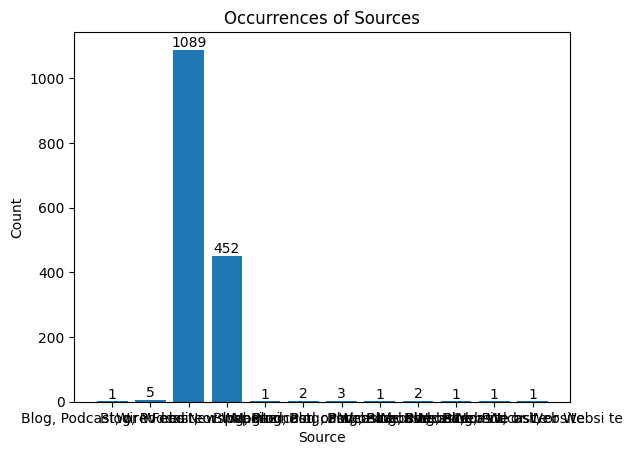

In [ ]:
vis_source(unique_list)

['flood', 'forestfire', 'blizzard', 'heatwave', 'freezing_rain', 'storm']
[138, 197, 186, 424, 373, 241]


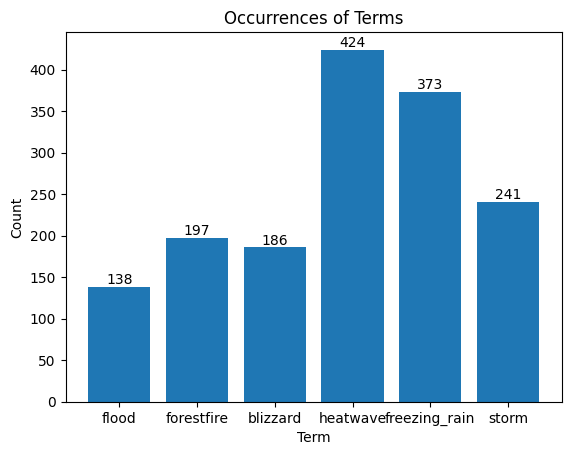

In [ ]:
vis_term(unique_list)

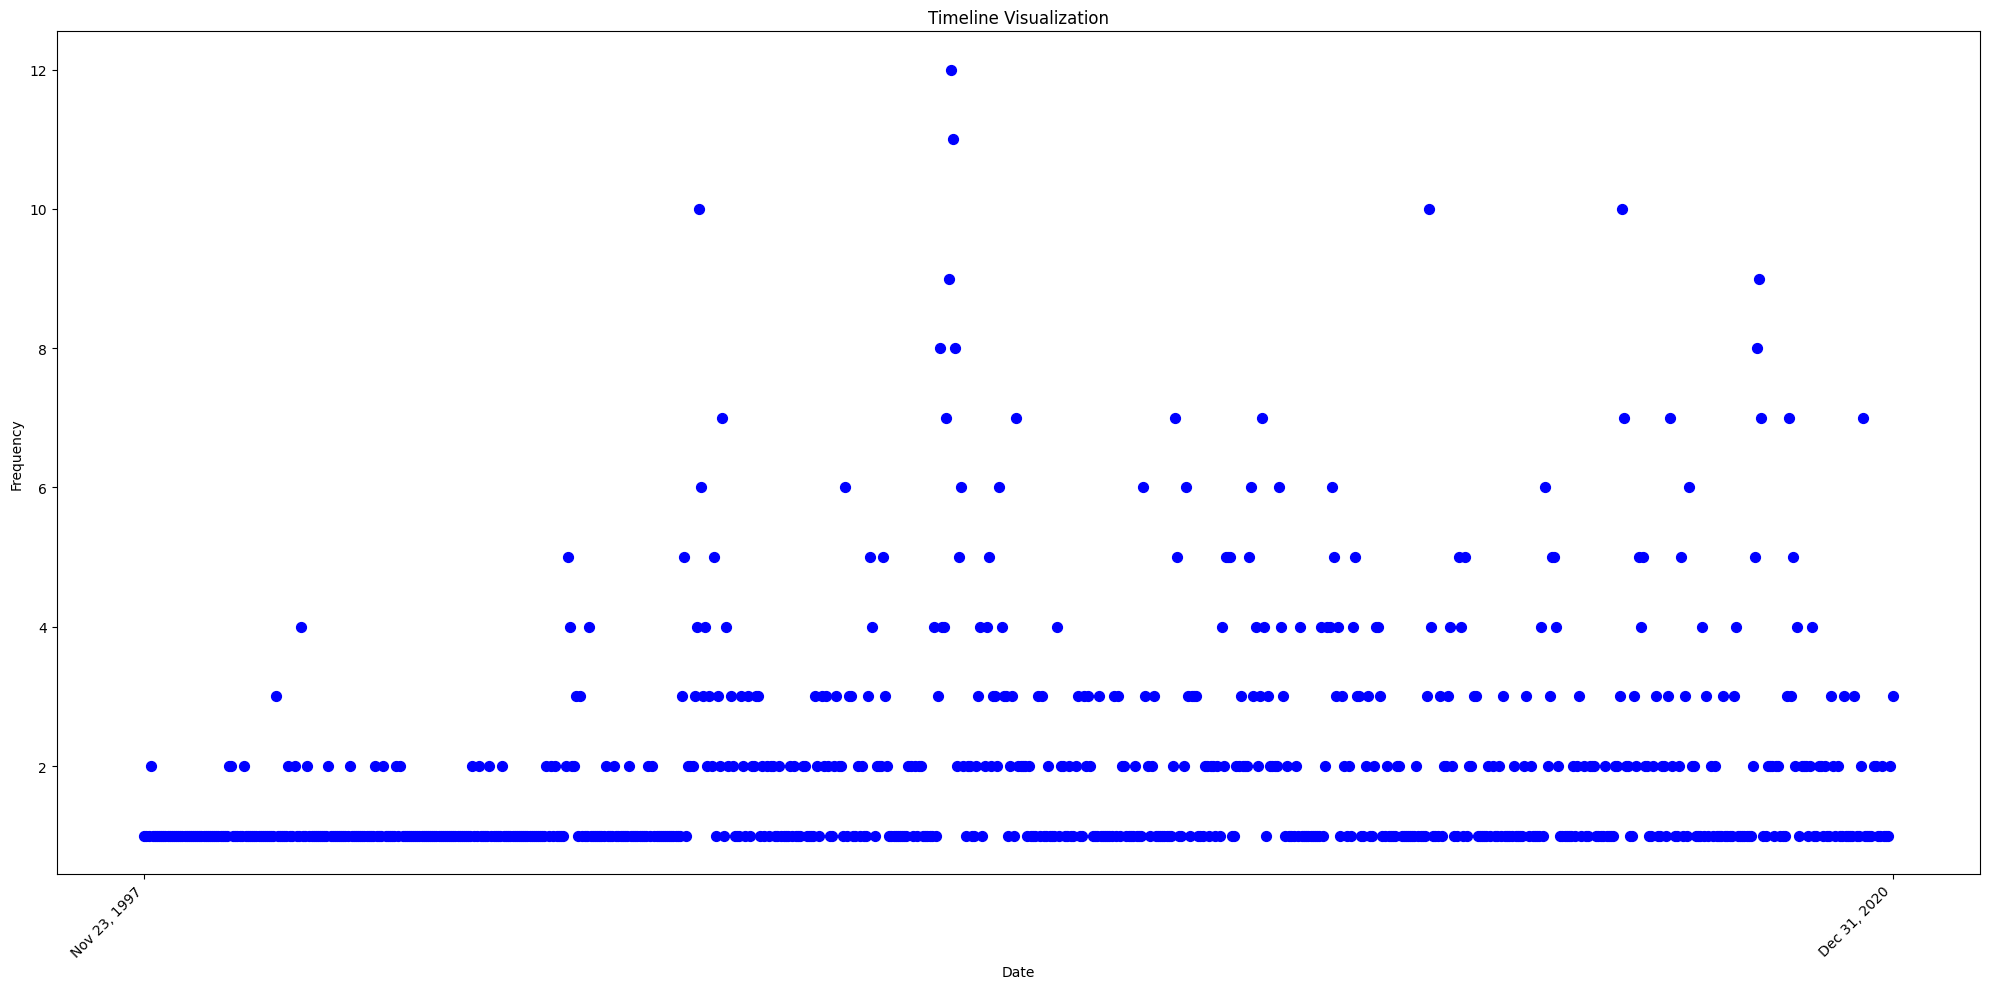

In [ ]:
vis_date(unique_list)